In [1]:
import torch
import pickle, time

/home/qidong/perfpred/torch_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import dgl
dgl.__version__

ModuleNotFoundError: No module named 'dgl'

In [1]:
dataset_file = 'nas_graphs.data'

def load_data_raw(filename):
    with open(filename, 'rb') as f:
        raw_data = pickle.load(f)
    return raw_data

t0 = time.time()
raw_data = load_data_raw(dataset_file)
dur = time.time() - t0

print(f"dataset loaded, cost {dur} s")

NameError: name 'time' is not defined

In [23]:
# construct graphs
graphs = []
labels = []

# transform type node_type into onehot
n_ntypes = 0
for node_type, _, _, _, _ in raw_data:
#     print(node_type)
    max_node_type = max(node_type)
    n_ntypes = max(n_ntypes, max_node_type)
n_ntypes += 1

for node_type, node_data, edge_list, edge_data, mem in raw_data:
    edge_list_tensor = torch.LongTensor(edge_list)
    node_type_tensor = torch.nn.functional.one_hot(torch.tensor(node_type), n_ntypes)
    ndata = torch.stack(node_data)
#     print(ndata.shape, node_type_tensor.shape)
    ndata = torch.concat([node_type_tensor, ndata], dim=1)
#     print(ndata.shape)
    edata = torch.tensor(edge_data)
    g = dgl.graph((edge_list_tensor[:, 0], edge_list_tensor[:, 1]))
    g.ndata['feat'] = ndata
    g.edata['feat'] = edata.float()
    graphs.append(g)
    labels.append(mem)
    
labels = torch.tensor(labels)

NameError: name 'raw_data' is not defined

In [157]:
# backup
with open("nas_graphs_dgl.data", "wb") as f:
    pickle.dump([graphs, labels], f)

In [24]:
with open("nas_graphs_dgl.data", "rb") as f:
    graphs, labels = pickle.load(f)


{'feat': tensor([[      1, 1048576],
        [      0, 1048576],
        [      1, 1048576],
        ...,
        [      0,   16384],
        [      0,  262144],
        [      0,       0]])}

(array([ 422.,  542.,  477., 1382.,  813.,  669., 1272.,  320.,  297.,
         209.]),
 array([ 770.,  848.,  926., 1004., 1082., 1160., 1238., 1316., 1394.,
        1472., 1550.]),
 <BarContainer object of 10 artists>)

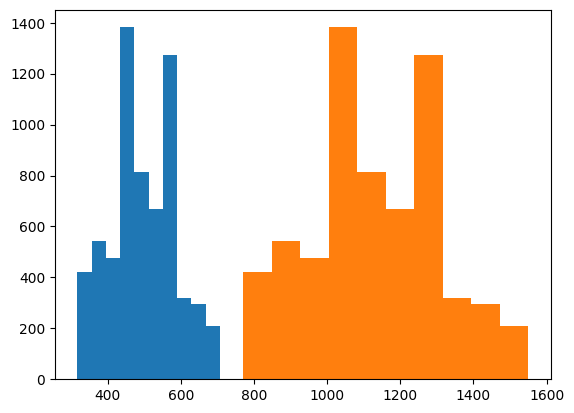

In [40]:
from matplotlib import pyplot as plt
num_nodes = [g.num_nodes() for g in graphs]
num_edges = [g.num_edges() for g in graphs]

plt.hist(num_nodes)
plt.hist(num_edges)

In [25]:
# normalize
num_ndata = graphs[0].ndata['feat'].shape[1]
num_edata = graphs[0].edata['feat'].shape[1]

max_ndata = []
min_ndata = []
max_edata = []
min_edata = []

for ndata_id in range(num_ndata):
    max_v = graphs[0].ndata['feat'][0, ndata_id]
    min_v = graphs[0].ndata['feat'][0, ndata_id]
    for g in graphs:
        max_v = max(max_v, torch.max(g.ndata['feat'][:, ndata_id]))
        min_v = min(min_v, torch.min(g.ndata['feat'][:, ndata_id]))
    if max_v != min_v:
        for g in graphs:
            g.ndata['feat'][:, ndata_id] = (g.ndata['feat'][:, ndata_id] - min_v)/(max_v - min_v)
    max_ndata.append(max_v)
    min_ndata.append(min_v)
            
for edata_id in range(num_edata):
    max_v = graphs[0].edata['feat'][0, edata_id]
    min_v = graphs[0].edata['feat'][0, edata_id]
    for g in graphs:
        max_v = max(max_v, torch.max(g.edata['feat'][:, edata_id]))
        min_v = min(min_v, torch.min(g.edata['feat'][:, edata_id]))
    if max_v != min_v:
        for g in graphs:
            g.edata['feat'][:, edata_id] = (g.edata['feat'][:, edata_id] - min_v)/(max_v - min_v)
    max_edata.append(max_v)
    min_edata.append(min_v)

In [26]:
from torch import nn
from torch.nn import functional as F

class ANEELayer(nn.Module):
    def __init__(self, ndim, edim, nlayers):
        super(ANEELayer, self).__init__()
        self.ndim = ndim
        self.edim = edim
        self.nlayers = nlayers
        
        self.Wu = nn.Parameter(torch.randn((ndim, ndim)))
        self.We = nn.Parameter(torch.randn((edim, edim)))
        self.a = nn.Parameter(torch.randn(2 * ndim))
        self.Wm = nn.Parameter(torch.randn(edim))
        
        self.W = nn.Parameter(torch.randn((ndim, )))
    
    def forward(self, g, ndata, edata):
        for i in range(self.nlayers):
            ndata = F.leaky_relu(ndata.matmul(self.Wu))
            u, v = g.edges(form='uv')
            uv_feat = torch.concat([ndata[u, :], ndata[v, :]], dim=-1)
    #         print(uv_feat.shape)
    #         print(edata.matmul(self.We).shape)
            new_edata = F.sigmoid(uv_feat.matmul(self.a).unsqueeze(1) * (edata.matmul(self.We)))
    #         Wme = F.softmax(new_edata.matmul(self.Wm))
            Wme = F.sigmoid(new_edata.matmul(self.Wm))
            new_ndata = dgl.ops.u_mul_e_sum(g, ndata, Wme)
            new_ndata = F.leaky_relu(new_ndata)
#             print(new_ndata.shape)
    #         print(new_edata.shape)
            ndata = new_ndata
            edata = new_edata
        ndata_sum = ndata.sum(dim=0)
        out = ndata_sum.matmul(self.W)
        
        return out

In [160]:
model = ANEELayer(44, 2, 2)
model(graphs[0], graphs[0].ndata['feat'], graphs[0].edata['feat'])

tensor(1200.5023, grad_fn=<DotBackward0>)

In [31]:
from tqdm import tqdm
import numpy as np

device='cuda'

model = ANEELayer(44, 2, 2)
model.to(device)
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

indices = np.random.permutation(range(len(graphs)))
n_train = int(0.7 * len(graphs))

graphs_gpu = [g.to(device) for g in graphs]

for epoch in range(10):
    errs = []
    for i in tqdm(indices[:n_train]):
        g = graphs_gpu[i]
        label = labels[i].to(device)
        optim.zero_grad()
        out = model(g, g.ndata['feat'], g.edata['feat'])
        err = torch.abs(out - label) / label
        errs.append(err.cpu().detach().numpy())
        loss = loss_fn(out, label)
        loss.backward()
        optim.step()
    #     print(loss)
    print(np.mean(errs))

100%|██████████████████████████████████████| 4482/4482 [00:30<00:00, 145.30it/s]


0.98378974


100%|██████████████████████████████████████| 4482/4482 [00:28<00:00, 156.80it/s]


0.27533457


100%|██████████████████████████████████████| 4482/4482 [00:28<00:00, 157.08it/s]


0.14721298


100%|██████████████████████████████████████| 4482/4482 [00:28<00:00, 157.82it/s]


0.13762957


100%|██████████████████████████████████████| 4482/4482 [00:29<00:00, 153.67it/s]


0.12682308


100%|██████████████████████████████████████| 4482/4482 [00:28<00:00, 156.39it/s]


0.11694984


100%|██████████████████████████████████████| 4482/4482 [00:28<00:00, 157.18it/s]


0.10841072


100%|██████████████████████████████████████| 4482/4482 [00:28<00:00, 156.28it/s]


0.10072584


100%|██████████████████████████████████████| 4482/4482 [00:29<00:00, 153.19it/s]


0.09329142


100%|██████████████████████████████████████| 4482/4482 [00:28<00:00, 155.82it/s]

0.08676987


In [75]:
errs = []
for i in tqdm(indices[n_train:]):
    g = graphs_gpu[i]
    label = labels[i].to(device)
    optim.zero_grad()
    out = model(g, g.ndata['feat'], g.edata['feat'])
    err = torch.abs(out - label) / label
    errs.append(err.cpu().detach().numpy())
    loss = loss_fn(out, label)
    loss.backward()
    optim.step()
#     print(loss)
print(np.mean(errs))

100%|██████████████████████████████████████| 1921/1921 [00:13<00:00, 145.06it/s]

0.080651365


In [29]:
import torchvision

In [66]:
from trace import Graph
example = torchvision.models.resnet18()
example.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [67]:
inputs = torch.rand((32, 3, 128, 128), device=device)
out = example(inputs)
raw_g = Graph(out)

In [68]:
node_type, node_data, edge_list, edge_data = raw_g.encode()

In [69]:
node_data[0].shape

torch.Size([20])

In [70]:
graphs[0].ndata['feat'].shape

torch.Size([437, 44])

In [71]:
edge_list_tensor[:, 0]

tensor([  0,   0,   1,   1,   2,   2,   3,   3,   3,   3,   4,   4,   5,   5,
          6,   6,   7,   7,   8,   8,   9,   9,  10,  10,  10,  10,  11,  11,
         12,  12,  13,  13,  14,  14,  15,  15,  16,  16,  17,  17,  17,  17,
         18,  18,  19,  19,  20,  20,  21,  21,  22,  22,  23,  23,  24,  24,
         25,  25,  26,  26,  26,  26,  27,  27,  28,  28,  29,  29,  30,  30,
         31,  31,  32,  32,  33,  33,  33,  33,  34,  34,  35,  35,  36,  36,
         37,  37,  38,  38,  39,  39,  40,  40,  41,  41,  42,  42,  42,  42,
         43,  43,  44,  44,  45,  45,  46,  46,  47,  47,  48,  48,  49,  49,
         49,  49,  50,  50,  51,  51,  52,  52,  53,  53,  54,  54,  55,  55,
         56,  56,  57,  57,  58,  58,  58,  58,  59,  59,  60,  60,  61,  61,
         62,  62,  63,  63,  64,  64,  65,  65,  66,  66,  69,  69,  70,  70,
         71,  71,  72,  72,  72,  73,  73,  74,  74,  75,  75,  76,  76,  77,
         77,  78,  78,  79,  79,  79,  80,  80,  81,  81,  82,  

In [72]:
edge_list_tensor = torch.LongTensor(edge_list)
node_type_tensor = torch.nn.functional.one_hot(torch.tensor(node_type), 24)
ndata = torch.stack(node_data)
ndata = torch.concat([node_type_tensor, ndata], dim=1)
edata = torch.tensor(edge_data)

g = dgl.graph((edge_list_tensor[:, 0], edge_list_tensor[:, 1]))

g.ndata['feat'] = ndata
g.edata['feat'] = edata.float()

In [73]:
# normalize
#max_ndata = []
#min_ndata = []
#max_edata = []
#min_edata = []

for i in range(len(max_ndata)):
    if max_ndata[i] != min_ndata[i]:
        g.ndata['feat'][:, i] = (g.ndata['feat'][:, i] - min_ndata[i]) / (max_ndata[i] - min_ndata[i])
        
for i in range(len(max_edata)):
    if max_edata[i] != min_edata[i]:
        g.edata['feat'][:, i] = (g.edata['feat'][:, i] - min_edata[i]) / (max_edata[i] - min_edata[i])

In [74]:
g = g.to(device)
model(g, g.ndata['feat'].cuda(), g.edata['feat'].cuda())

tensor(-288.9028, device='cuda:0', grad_fn=<DotBackward0>)

In [110]:
graphs[0].num_edges()

1010